#Final Implementation

In [1]:
!pip install nnfs
import numpy as np
from nnfs.datasets import vertical_data
import nnfs
nnfs.init()
from matplotlib import pyplot as plt

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 882.6 kB/s eta 0:00:14
   - -------------------------------------- 0.5/12.8 MB 882.6 kB/s eta 0:00:14
   -- ------------------------------------- 0.8/12.8 MB 744.7 kB/s eta 0:00:17
   -- ------------------------------------- 0.8/12.8 MB 744.7 kB/s eta 0:00:17
   --- ------------------------------------ 1.0/12.8 MB 751.1 kB/s eta 0:00:16
   ---- ----------------------------------- 1.3/12.8 MB 762.6 kB/s eta 0:00:16
   ---- ----------------------------------- 1.3/12.8 MB 762.6 kB/s eta 0:00:16
   ---- ----------------------------------- 1.6/12.8 MB 755.5 kB/s eta 0:00:15
   ---- ----------------------------------- 1.6/12.8 MB 755.5 kB/s eta 0:00:15
   ----- ---------------------------------- 1.8/12.8 MB 729.2 kB/s eta 0:00:16



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'matplotlib'

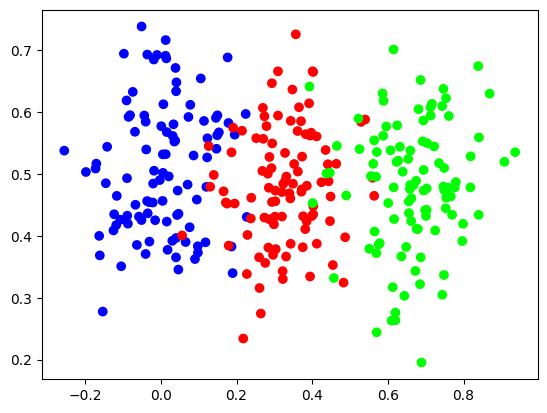

In [13]:
X,y = vertical_data(samples = 100, classes =3)
plt.scatter(X[:,0],X[:,1],c=y,cmap='brg')

In [14]:
#classes
class Dense_Layer:
  def __init__ (self,n_inputs,n_neurons):
    self.weights = np.random.randn(n_inputs, n_neurons)
    self.biases = np.zeros((1,n_neurons))
  def forward(self,inputs):
    self.output = np.dot(inputs,self.weights)+self.biases

class Relu:
  def forward(self,inputs):
    self.output = np.maximum(0,inputs)
class softmax:
  def forward(self,inputs):
    exp_values = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
    probabilities = exp_values/np.sum(exp_values,axis=1,keepdims = True)
    self.output = probabilities

class Loss:
  def calculate(self,x,y):
    sample_losses = self.forward(x,y)
    return np.mean(sample_losses)

class Crossentropyloss(Loss):
  def forward(self,y_pred,y_target):
    samples = len(y_pred)
    y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)

    if len(y_target.shape)==1:
      required_confidences = y_pred_clipped[range(samples),y_target]
    elif len(y_target.shape)==2:
      required_confidences= np.sum(y_pred_clipped*y_target,axis=1)

    losses = -np.log(required_confidences)
    return losses

###RandomSearch for weights and biases

In [15]:
#create network
layer1 = Dense_Layer(2,3)
activation1 = Relu()
layer2 = Dense_Layer(3,3)
activation2 = softmax()
loss_function = Crossentropyloss()

#variables
lowest_loss = 999999
best_l1_weights = layer1.weights.copy()
best_l1_biases = layer1.biases.copy()
best_l2_weights = layer2.weights.copy()
best_l2_biases = layer2.biases.copy()

for i in range(100000):
  #New set of weights and biases each iteration
  layer1.weights = 0.05 * np.random.randn(2, 3)
  layer1.biases = 0.05 * np.random.randn(1, 3)
  layer2.weights = 0.05 * np.random.randn(3, 3)
  layer2.biases = 0.05 * np.random.randn(1, 3)

  layer1.forward(X)
  activation1.forward(layer1.output)
  layer2.forward(activation1.output)
  activation2.forward(layer2.output)
  loss = loss_function.calculate(activation2.output,y)


  predictions = np.argmax(activation2.output,axis=1)
  accuracy = np.mean(predictions==y)

  if loss<lowest_loss:
    print("New weights found, iteration",i,"loss: ",loss,"acc",accuracy)
    best_l1_weights=layer1.weights.copy()
    best_l1_biases=layer1.biases.copy()
    best_l2_weights=layer2.weights.copy()
    best_l2_biases= layer2.biases.copy()
    lowest_loss=loss

New weights found, iteration 0 loss:  1.0986564 acc 0.3333333333333333
New weights found, iteration 3 loss:  1.098138 acc 0.3333333333333333
New weights found, iteration 117 loss:  1.0980115 acc 0.3333333333333333
New weights found, iteration 124 loss:  1.0977516 acc 0.6
New weights found, iteration 165 loss:  1.0975711 acc 0.3333333333333333
New weights found, iteration 552 loss:  1.0974693 acc 0.34
New weights found, iteration 778 loss:  1.0968257 acc 0.3333333333333333
New weights found, iteration 4307 loss:  1.0965533 acc 0.3333333333333333
New weights found, iteration 4615 loss:  1.0964499 acc 0.3333333333333333
New weights found, iteration 9450 loss:  1.0964295 acc 0.3333333333333333
New weights found, iteration 13361 loss:  1.0963014 acc 0.3333333333333333
New weights found, iteration 14001 loss:  1.0959858 acc 0.3333333333333333
New weights found, iteration 24598 loss:  1.0947443 acc 0.3333333333333333


###Search with optimisations
1. If the loss decreases, pick W&B closer to the current ones
2. If the loss increased, keep the previous W&B, don't update

In [22]:
#create network
layer1 = Dense_Layer(2,3)
activation1 = Relu()
layer2 = Dense_Layer(3,3)
activation2 = softmax()
loss_function = Crossentropyloss()

#memory variables
lowest_loss = 999999
best_l1_weights = layer1.weights.copy()
best_l1_biases = layer1.biases.copy()
best_l2_weights = layer2.weights.copy()
best_l2_biases = layer2.biases.copy()

for i in range(100000):
  #New set of weights and biases each iteration
  layer1.weights += 0.05 * np.random.randn(2, 3)
  layer1.biases += 0.05 * np.random.randn(1, 3)
  layer2.weights += 0.05 * np.random.randn(3, 3)
  layer2.biases += 0.05 * np.random.randn(1, 3)

  layer1.forward(X)
  activation1.forward(layer1.output)
  layer2.forward(activation1.output)
  activation2.forward(layer2.output)
  loss = loss_function.calculate(activation2.output,y)


  predictions = np.argmax(activation2.output,axis=1)
  accuracy = np.mean(predictions==y)

  if loss<lowest_loss:
    print("New weights found, iteration",i,"loss: ",loss,"acc",accuracy)
    best_l1_weights=layer1.weights.copy()
    best_l1_biases=layer1.biases.copy()
    best_l2_weights=layer2.weights.copy()
    best_l2_biases= layer2.biases.copy()
    lowest_loss=loss

  else:
    layer1.weights = best_l1_weights.copy()
    layer1.biases = best_l1_biases.copy()
    layer2.weights = best_l2_weights.copy()
    layer2.biases = best_l2_biases.copy()

New weights found, iteration 0 loss:  1.4923058 acc 0.3333333333333333
New weights found, iteration 3 loss:  1.479865 acc 0.3333333333333333
New weights found, iteration 4 loss:  1.4329771 acc 0.3333333333333333
New weights found, iteration 8 loss:  1.4244839 acc 0.3333333333333333
New weights found, iteration 9 loss:  1.4172835 acc 0.3333333333333333
New weights found, iteration 11 loss:  1.3941227 acc 0.3333333333333333
New weights found, iteration 13 loss:  1.3696911 acc 0.3333333333333333
New weights found, iteration 14 loss:  1.3188618 acc 0.3333333333333333
New weights found, iteration 15 loss:  1.2629676 acc 0.3333333333333333
New weights found, iteration 16 loss:  1.235717 acc 0.3333333333333333
New weights found, iteration 17 loss:  1.2147206 acc 0.3333333333333333
New weights found, iteration 20 loss:  1.2129995 acc 0.3333333333333333
New weights found, iteration 21 loss:  1.1693839 acc 0.3333333333333333
New weights found, iteration 22 loss:  1.1624367 acc 0.3333333333333333